<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Intro to Support Vector Machines

---
## Support Vector Machine


We're going to add another model to our toolkit: Support Vector Machine or SVM. 

The SVM was the original king of machine learning as it used an insightful trick to be able to quickly make predictions after a model was fit. While new models have arisen since it's heyday 10 years ago, it's still a powerful and effective model. Let's learn a little bit about it.

### Key Terms:
- Support Vector Machine
- Baseline Baseline Accuracy
- Model Hyperparameter

### Expected Knowledge:
- Manipulating data with Pandas




In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets import fetch_lfw_people


# use seaborn plotting defaults
import seaborn as sns; sns.set()


/Users/bar/dev/miniconda/envs/ga/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Let's use sklearn's ```make_blobs``` to generate some simple data.

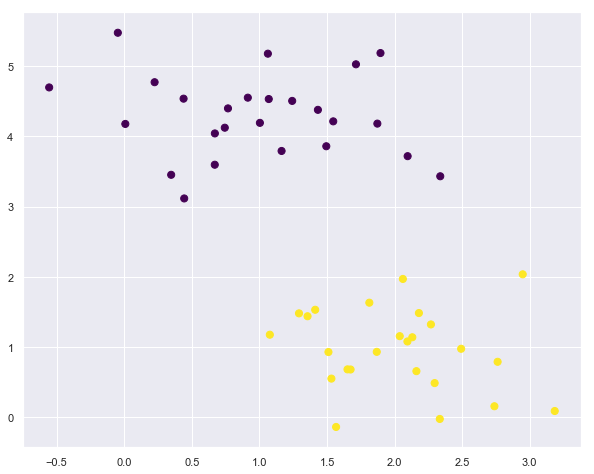

In [2]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis');

As mentioned above a line is 'hyperplane' in two dimensions. So our classifier needs to draw a straight line separating the two blobs. We could do this by hand since we can easily see how to draw a line separating the two classes. 

What is the problem with this approach?

**Problem** there is more than one possible line that can perfectly discriminate between the two classes!

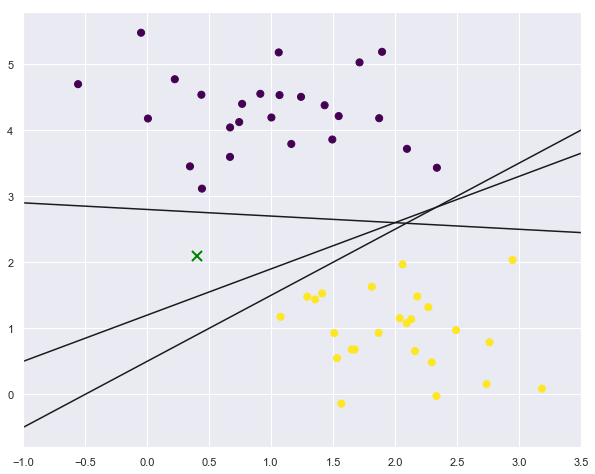

In [3]:
xfit = np.linspace(-1, 3.5)
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.plot([0.4], [2.1], 'x', color='green', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.5), (0.7, 1.2), (-0.1, 2.8)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Three different lines each can distinguish perfectly between the two samples. However, which line you choose will impact how new data points are classified.  Consider the red  "X" in this plot: it will be assigned a different label depending on which line we use as our classifier. So it's not enough to simply draw a hyperplane through our feature space. We need to consider other criteria.

### How Support Vector Machines Work
Support Vector Machines don't simply generate a hyperplane or in the case above a zero-width line. Instead they draw around each line a margin of some width, up to the nearest point in each of the blobs. It might look as follows:



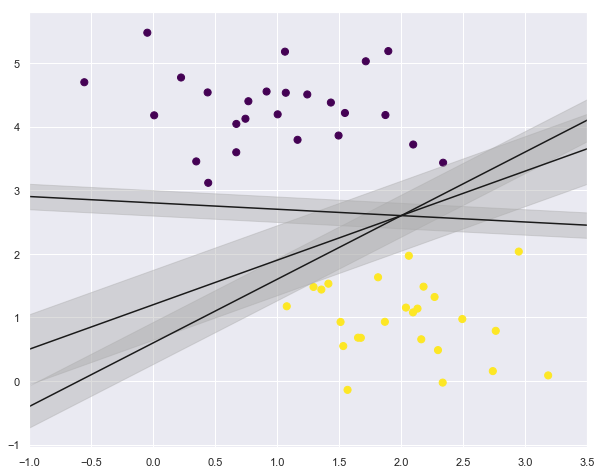

In [4]:
xfit = np.linspace(-1, 3.5)
fig = plt.figure(figsize=(10,8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

for m, b, d in [(1, 0.6, 0.33), (0.7, 1.2, 0.55), (-0.1, 2.8, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);


For SVM the line that maximizes the margin gives us the optimal model. This is an example of a *maximum margin estimator*.

### Building an SVM Classifier

In [5]:
# Instantiate
svm = SVC(kernel='linear', C=1E10)


# Fit
svm.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

We can use the function below to plot the decision boundary of our classifier.

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

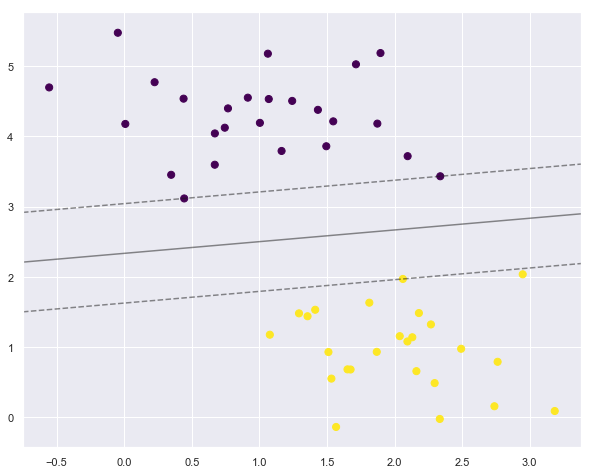

In [7]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(svm);

The line (aka hyperplane denoted by the solid line) is the line that maximizes the margin between the two sets of points. The margin in this case is the distance from the line to each of the dotted lines. Notice that a few of the training points just touch the margin. These points are the critical elements of this model, and are known as the support vectors, hence the name. We can access these points in ```sklearn``` using the attribute of our fitted model ```svm.support_vectors_ attribute```.

In [8]:
svm.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

It's important to note that only the position of the support vectors matter and any points further from the margin and on the correct side do not modify the solution. Practically speaking these points don't contribute to the loss function used to fit the model and their position and number don't matter provided they are on the correct side of the margin.

The plots below illustrate this, for example, if we plot the model learned from the first 60 points and then first 180 points of this dataset:

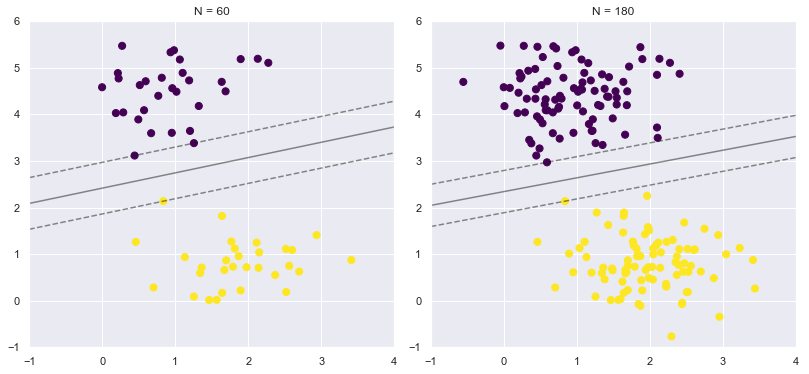

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 180]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

On the left we have the support vectors for 60 training points. On the right, we have triple the number of training points, but the model has not changed: the three support vectors computed from 60 points are the same as computed from 180 data points. SVMs are insensitive to the exact behavior outliers and is one of the strengths of the SVM approach. 

### SVM Kernel 

The data above was easily separable. What happens when we don't have easily separated data? How does SVM work?

The idea is mapping the non-linear separable data-set into a higher dimensional space where we can find a hyperplane that can separate the samples. Consider the following data:

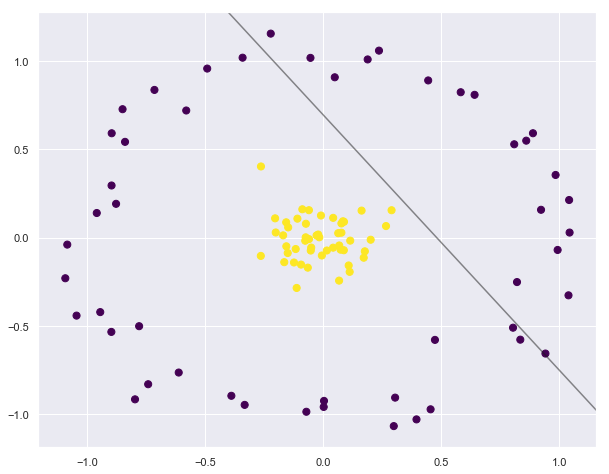

In [10]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)


fig = plt.figure(figsize=(10,8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(clf, plot_support=False);

Clearly SVM is not providing a credible solution to classifying this data set. However, consider if we project this data into 3-dimensions as follows:



In [11]:
# This function will define our projection. In this case we're using a radial basis function.
z = np.exp(-((X) ** 2).sum(1))


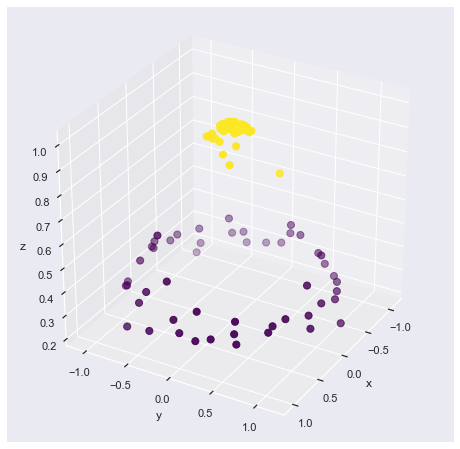

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap='viridis')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

fig = plt.figure(figsize=(8,8))


plot_3D()



By projecting into a higher dimension the data becomes trivially linearly separable. We could draw hyperplane at ```z=0.6``` and achieve a perfect separation.

This isn't arbitrary since we chose our projection carefully. We centered our radial function in the right location (i.e. centered on the yellow blob). If we hadn't we would not have had an easily separable result. In practice, the need to make such a choice is problematic and it would be nice to somehow automatically find the best basis functions to use.

One approach is to compute a basis function centered at every point in the data, and let the SVM algorithm sift through the results. This approach is based on a similarity relationship (or kernel) between each pair of points and is known as a kernel transformation and involve projecting N points into N dimensions.

### The Kernel Trick
This type of projection (N points into N dimensions) is computationally intensive as N becomes large. However, because of a procedure known as the kernel trick, we can fit to the kernel-transformed data can be done implicitly. Meaning we don't need to build the full N-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

#### SVM Kernel in sklearn

In Scikit-Learn, we can apply the kernel trick simply by changing the linear kernel to an RBF (radial basis function) kernel, when we instantiate the SVM classifier.


In [13]:
# Instantiate
svmk = SVC(kernel='rbf', C=1E6)

# Fit
svmk.fit(X, y)

SVC(C=1000000.0)

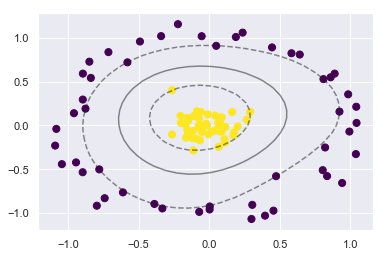

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plot_svc_decision_function(svmk)
plt.scatter(svmk.support_vectors_[:, 0], svmk.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

The kernel trick enabled finding a nonlinear decision boundary. And we're able to leverage fast linear methods to find non-linear solutions just as quickly.

### SVM Tuning

What happens when we have ill-defined boundaries between our clusters? How do we tune SVM to improve our results?

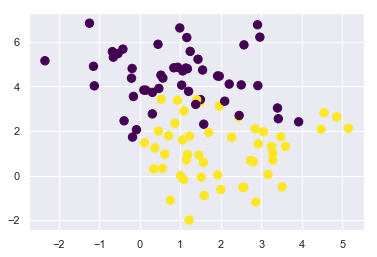

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='viridis');

Let's look at data that, while not overlapping is still very closely spaced.

Remember that the margins, in general, are defined by the support vectors (points that define the the edge of the margin) and no points can lie inside the margins. The hyperparameter $C$, is used to define the "hardness" of the margins. That is, larger values of $C$ correspond to harder margins and no points can lie inside them. Smaller values of $C$ will allow some points to exist inside the margins.

As with other methods we can use grid-search and cross-validation to find optimal values for $C$.

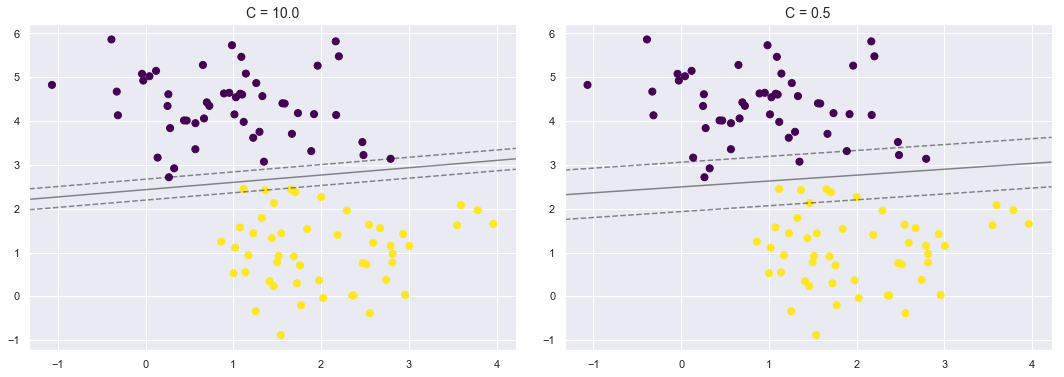

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, .5]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

In [17]:
faces = fetch_lfw_people(min_faces_per_person=70)

In [18]:
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 62, 47)


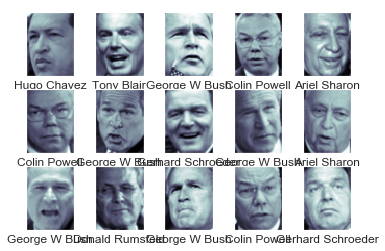

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [26]:


pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
pipeline = make_pipeline(pca, svc)

In [27]:
# Train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [28]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(pipeline, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 53.8 s, sys: 2.51 s, total: 56.3 s
Wall time: 30.4 s
{'svc__C': 1, 'svc__gamma': 0.005}


In [29]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

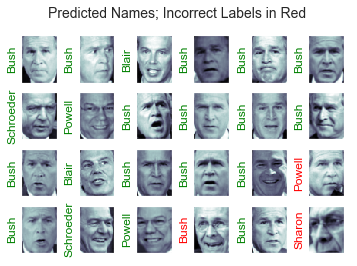

In [30]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='green' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [31]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.74      0.92      0.82        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.93      0.92      0.93       146
Gerhard Schroeder       0.92      0.88      0.90        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.88      0.83      0.86        36

         accuracy                           0.86       322
        macro avg       0.83      0.78      0.80       322
     weighted avg       0.87      0.86      0.86       322



Remember that precision penalizes false positives and recall false negatives

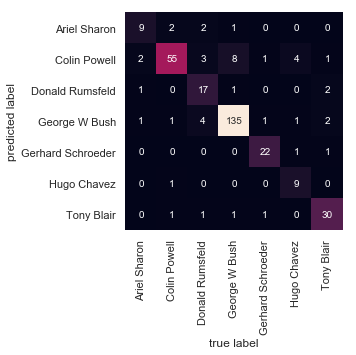

In [32]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Support Vector Machine Classifier


- [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine)

**Background** The goal of a support vector machine is to find  the optimal separating hyperplane which maximizes the margin of the training data. 

**Pros**:
    - Powerful Model
    - Popularized modern machine learning due to it's extreme power (dethroned by Deep Learning)
    - Robust to outliers
    - Uses the kernel trick 
      
**Cons**:
    - Many possible settings
    - Slow to train
    - Scale matters
    - Can be a black box (it's hard to understand how or why it makes predictions)
    - Does not provide predicted probabilities
    
**What do we know?**

- It needs training data so it's a supervised model
- We're using it for classification

**What do we not know**
- How does it make predictions?
- What is a hyperplane?

Those questions are inherently linked. A **hyperplane** is the seperation of space between our classes. If we break it down further we can better understand it.

- in one dimension, an hyperplane is called a point
- in two dimensions, it is a line
- in three dimensions, it is a plane
- in more dimensions you can call it an hyperplane

As we start to understand that concept it begs another question. I can draw alot of lines so which is the right one? That's the goal of the SVM - **Finding the optimal hyperplane**. Finding this optimal hyperplane is dependent on a few particular vectors that support its placement - or support vectors.

Support Vectors are the data points closest to the hyperplane or decision line. These are the data points that are the **most difficult** to classify. Given their proximity to the hyperplane they have direct bearing on its optimum location. Essentially Support vectors would change the elements of the training set if moved or removed and are critical elements of the training set.

![image.png](./assets/SupportVector.png)


**Now to optimize our hyperlane!**

Step 1 - Seperate the plane as far as you can from data
![Optimal Hyperplane](./assets/optimal-hyperplane.png)

Step 2 - Find the hyperplane with the largest margin

For any hyperplane we can compute the margin.
 - Find the distance between the hyperplane and the closest data point. 
 - Take that distance and double it
 
Now you have the **margin**. Basically the margin is an area where you will not find any data points. (Note: this can cause some problems when data is noisy)

![Margin](./assets/margin.png)





### Kernel Trick: For when our data isn't already linearly separable

The below picture shows the true magic behind a Support Vector Machine. The objects on the left are mapped as we'd originally find them. A full seperation would require a curve and thus more complexity than drawing a line. In a support vector machine we rearrange using a set of mathmatical functions known as **kernels**. An intuitive way to think about kernels is a similarity function. Given two objects the kernel outputs some similarity score. The simpliest example is the linear kernel or dot-product. Given two vectors, the similarity is the lenght of hte projections of one vector to another. Given a data point to classify, the decision function makes use of the kernel by comparing that data point to a number of support vectors weighted by the learned parameters. The support vectors are in the domain of that data point and along the learned parameters are found by the learning algorithm. 

![Kernels](./assets/Input_Feature.gif)

### Sometimes it's helpful to see this in 3d

While it's hard to draw a line to divide the classes in the picture on the left, it's easy on the right

![Kernels-2d-to-3d](./assets/2d-to-3d.png)

### Another example

<img src="./assets/2d-to-3d-projection.jpeg" width="600">

#### Parameters

>class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

Today we're going to adjust C. The C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly
by giving the model freedom to select more samples as support vectors. 

![BigC_LittleC](./assets/BigC_LittleC.png)

As we regularize, or penalize C, we can visualize the impact on our predictions
![Regularize](./assets/c_regulation.png)

Note: 
* Here's a good source on [understanding the math](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/) or [The Idiot's Guide to SVM](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf)
* Learn more about [Kernels](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick)

In [33]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (10, 10)

# Lesson Structure:

In this lesson, you will build two types of classifiers

1. A [Logistic Regression Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. A [Suport Vector Machine Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

We will train these models on a dataset of tumors, aiming to classify a given tumor as benign or malignant. 

### Steps:
---
**1. EDA**
    - Analyze the dataset, mostly through visualizations.
**2. Data Preparation**
    - Handle non-numeric features.
    - Handle missing values.
    - Compute the baseline accuracy.
**3. Model Training**
    - Performing a train-test split on our data
    - Fitting the models of your choice (today: LogisticRegression and SVC) on the training data.
    - Scoring our trained models on the test data.
    
**4. Model Evaluation**
    - Gaining an understanding of how our model makes predictions.
    - Tuning our model to obtain better results.

![](http://www.biosytechworld.com/media/3188/123.jpg)

In [34]:
df = pd.read_csv('./data/cancer_uci.csv', index_col='Unnamed: 0')

df.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,Benign
1,1002945,5,4,4,5,7,10,3,2,1,Benign
2,1015425,3,1,1,1,2,2,3,1,1,Benign
3,1016277,6,8,8,1,3,4,3,7,1,Benign
4,1017023,4,1,1,3,2,1,3,1,1,Benign


# Part 1: EDA

Verifying Data Integrity

In [35]:
# Check the number of rows and columns of our dataset
df.shape

(699, 11)

In [36]:
# Check the data types and verify we have no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           699 non-null    int64 
 1   Clump_Thickness              699 non-null    int64 
 2   Uniformity_of_Cell_Size      699 non-null    int64 
 3   Uniformity_of_Cell_Shape     699 non-null    int64 
 4   Marginal_Adhesion            699 non-null    int64 
 5   Single_Epithelial_Cell_Size  699 non-null    int64 
 6   Bare_Nuclei                  699 non-null    object
 7   Bland_Chromatin              699 non-null    int64 
 8   Normal_Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    object
dtypes: int64(9), object(2)
memory usage: 65.5+ KB


In [37]:
# Confirming dtypes
df.dtypes

Sample_code_number              int64
Clump_Thickness                 int64
Uniformity_of_Cell_Size         int64
Uniformity_of_Cell_Shape        int64
Marginal_Adhesion               int64
Single_Epithelial_Cell_Size     int64
Bare_Nuclei                    object
Bland_Chromatin                 int64
Normal_Nucleoli                 int64
Mitoses                         int64
Class                          object
dtype: object

In [38]:
# For our non-numeric columns, explore how many (and what) categories we have
df['Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [39]:
# Looking for pairwise correlations between the features (Heatmap)
df.corr()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses
Sample_code_number,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.060051,-0.052072,-0.034901
Clump_Thickness,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034
Uniformity_of_Cell_Size,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693
Uniformity_of_Cell_Shape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911
Marginal_Adhesion,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633
Single_Epithelial_Cell_Size,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101
Bland_Chromatin,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169
Normal_Nucleoli,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336
Mitoses,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000


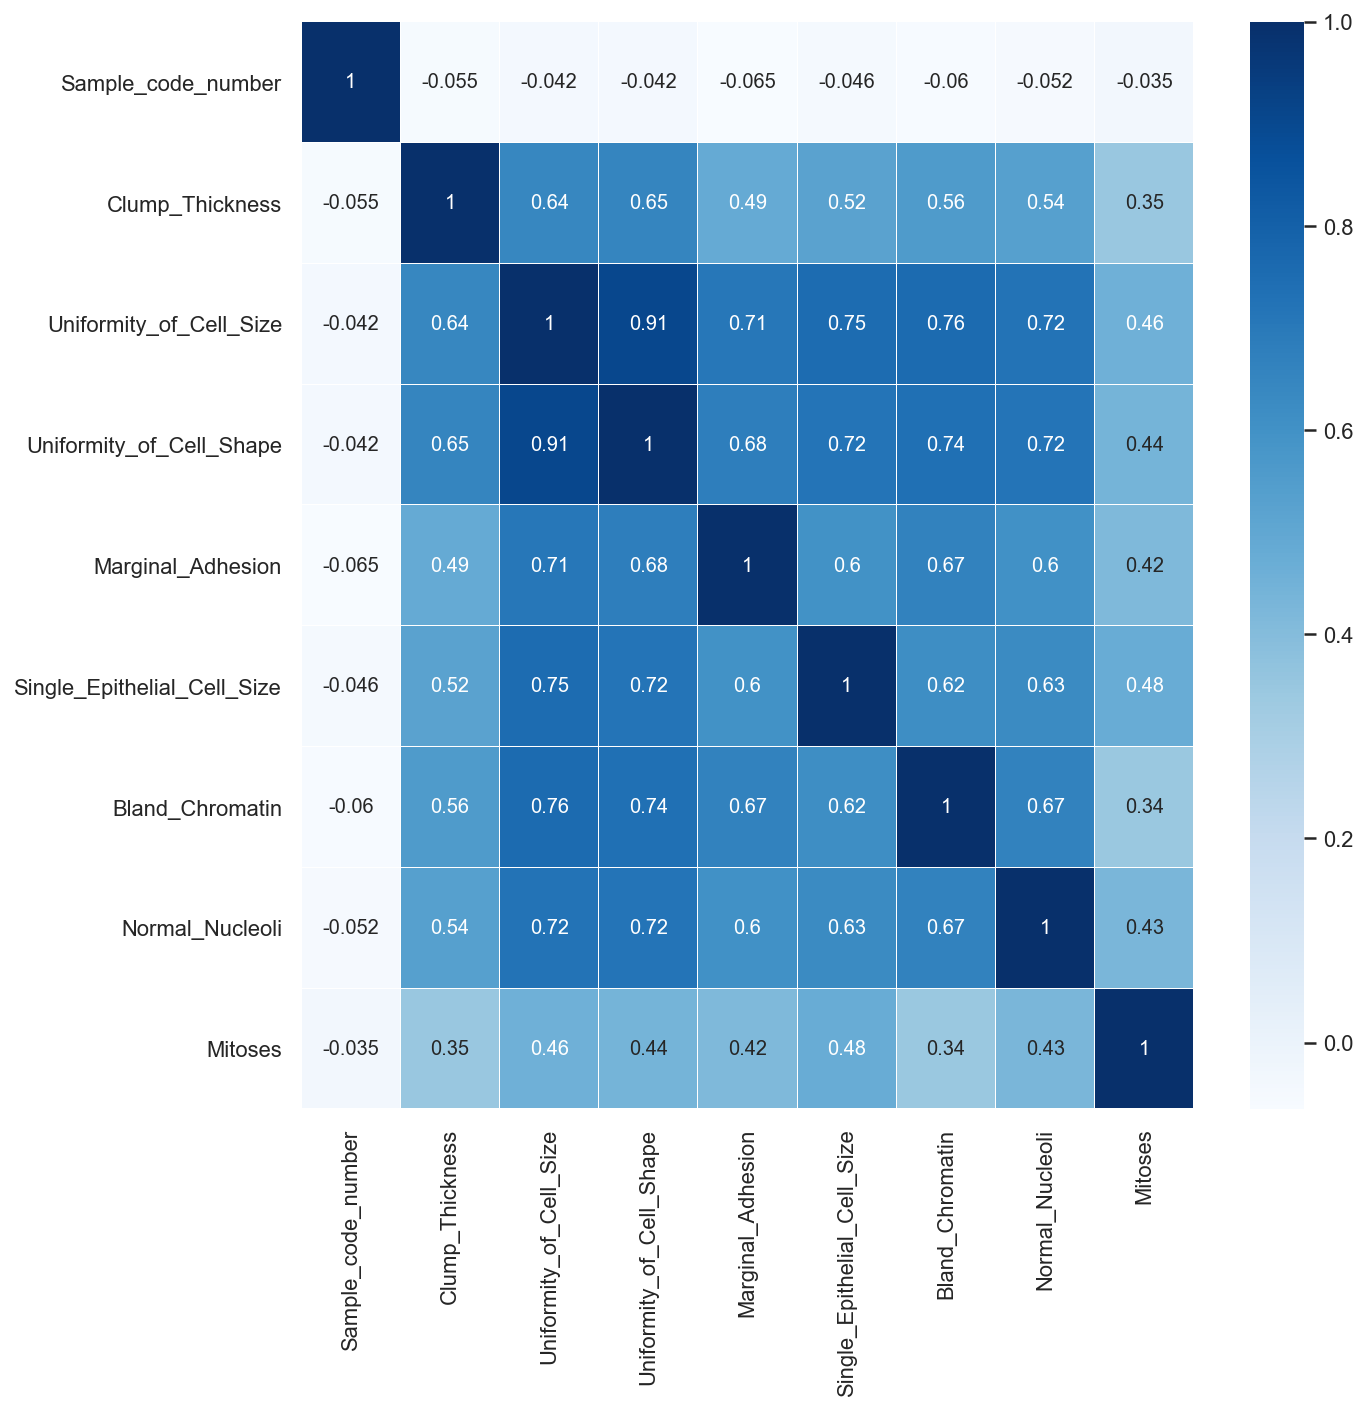

In [40]:
# NOTE: As a learning experience, run sns.pairplot on this data
# Also try: sns.pairplot(df, hue='Class', plot_kws={'alpha':0.1})
sns.heatmap(df.corr(),annot=True,linewidths=0.01, cmap='Blues');

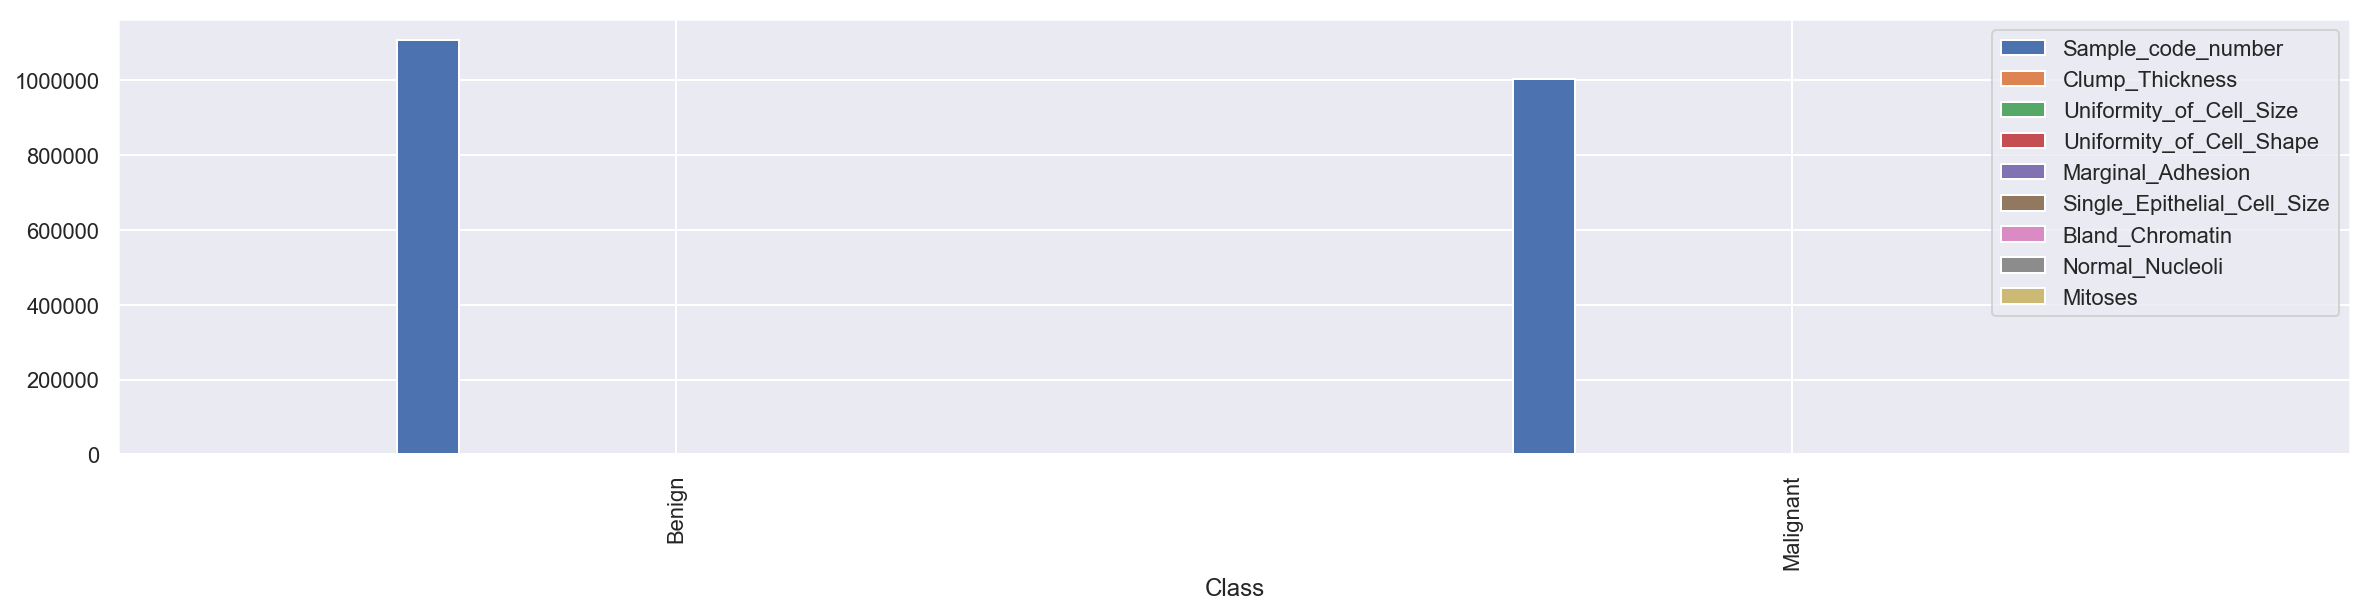

In [41]:
# Groupby is also a great EDA tool

df.groupby('Class').mean().plot(kind='bar', figsize=(20,4))

# Part 2: Preparing the data

In [42]:
# Drop columns you will not use
data = df.drop(['Sample_code_number'], axis=1)

In [43]:
# Handle 'bad data'
data['Bare_Nuclei'] = data['Bare_Nuclei'].apply(lambda x: np.nan if x =='?' else float(x))

### Installing a python library

To install `missingno` run `!pip install missingno` in a cell. You only ever need to do this once.

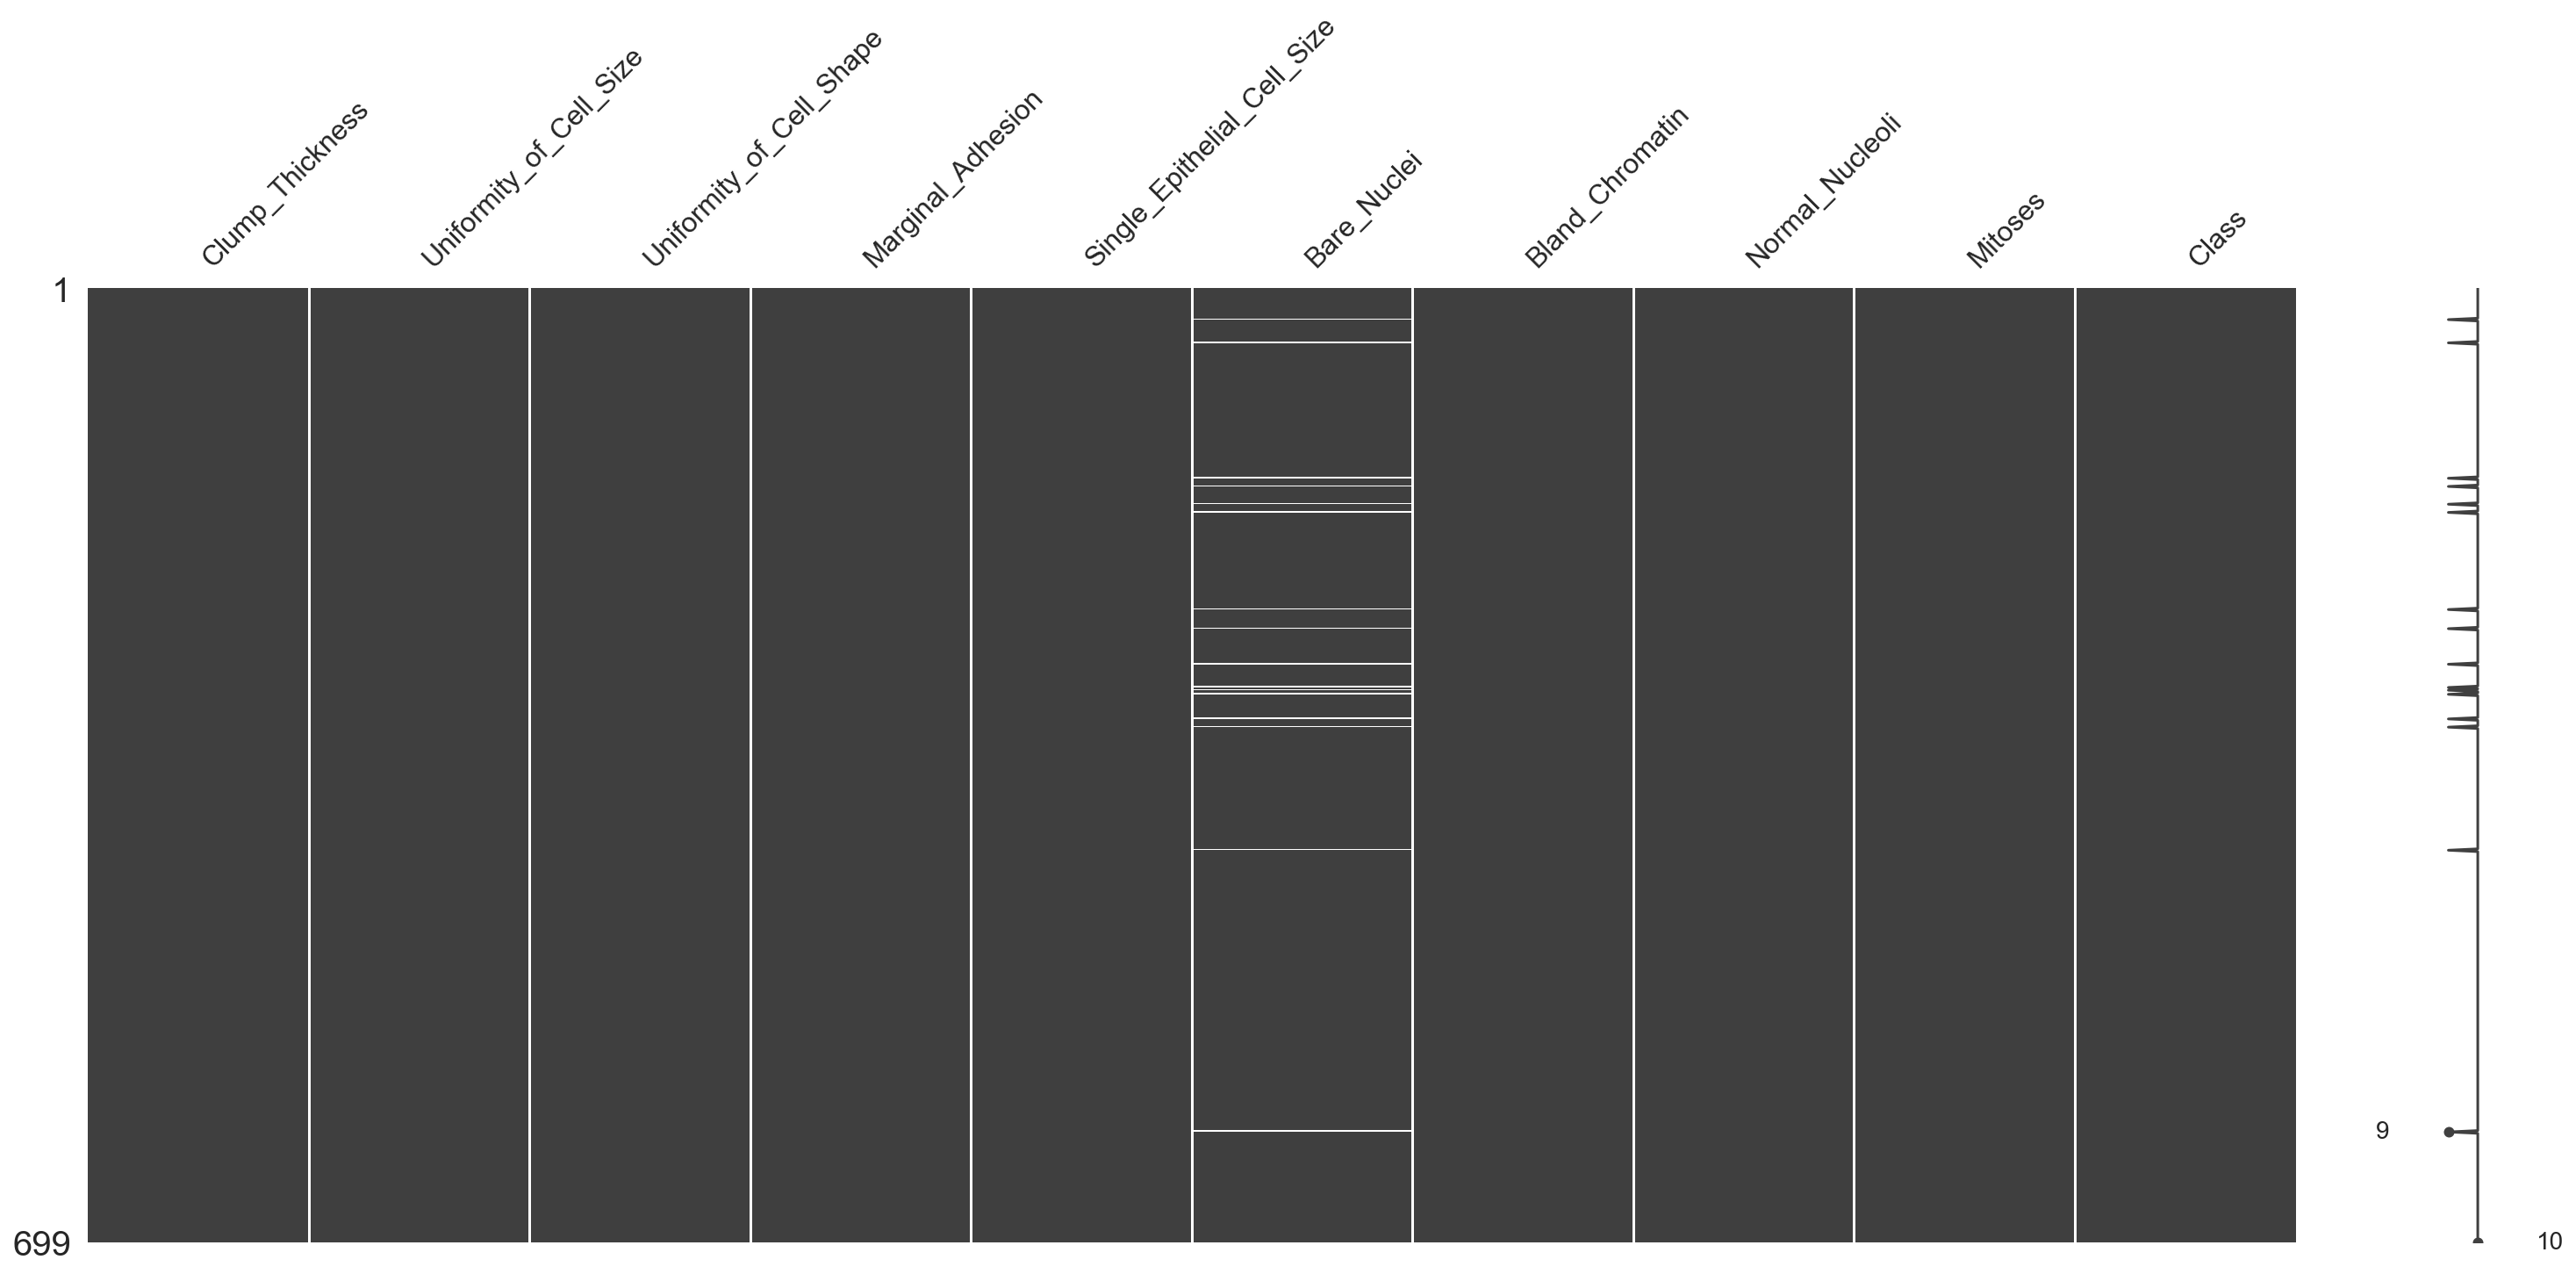

In [44]:
# Discover bad data:
# Option 1: data.isnull().sum()
# Option 2: data.isnull().mean()

import missingno as msgn
msgn.matrix(data)

In [45]:
# Drop rows with missing values

clean_data = data.dropna(how='any')

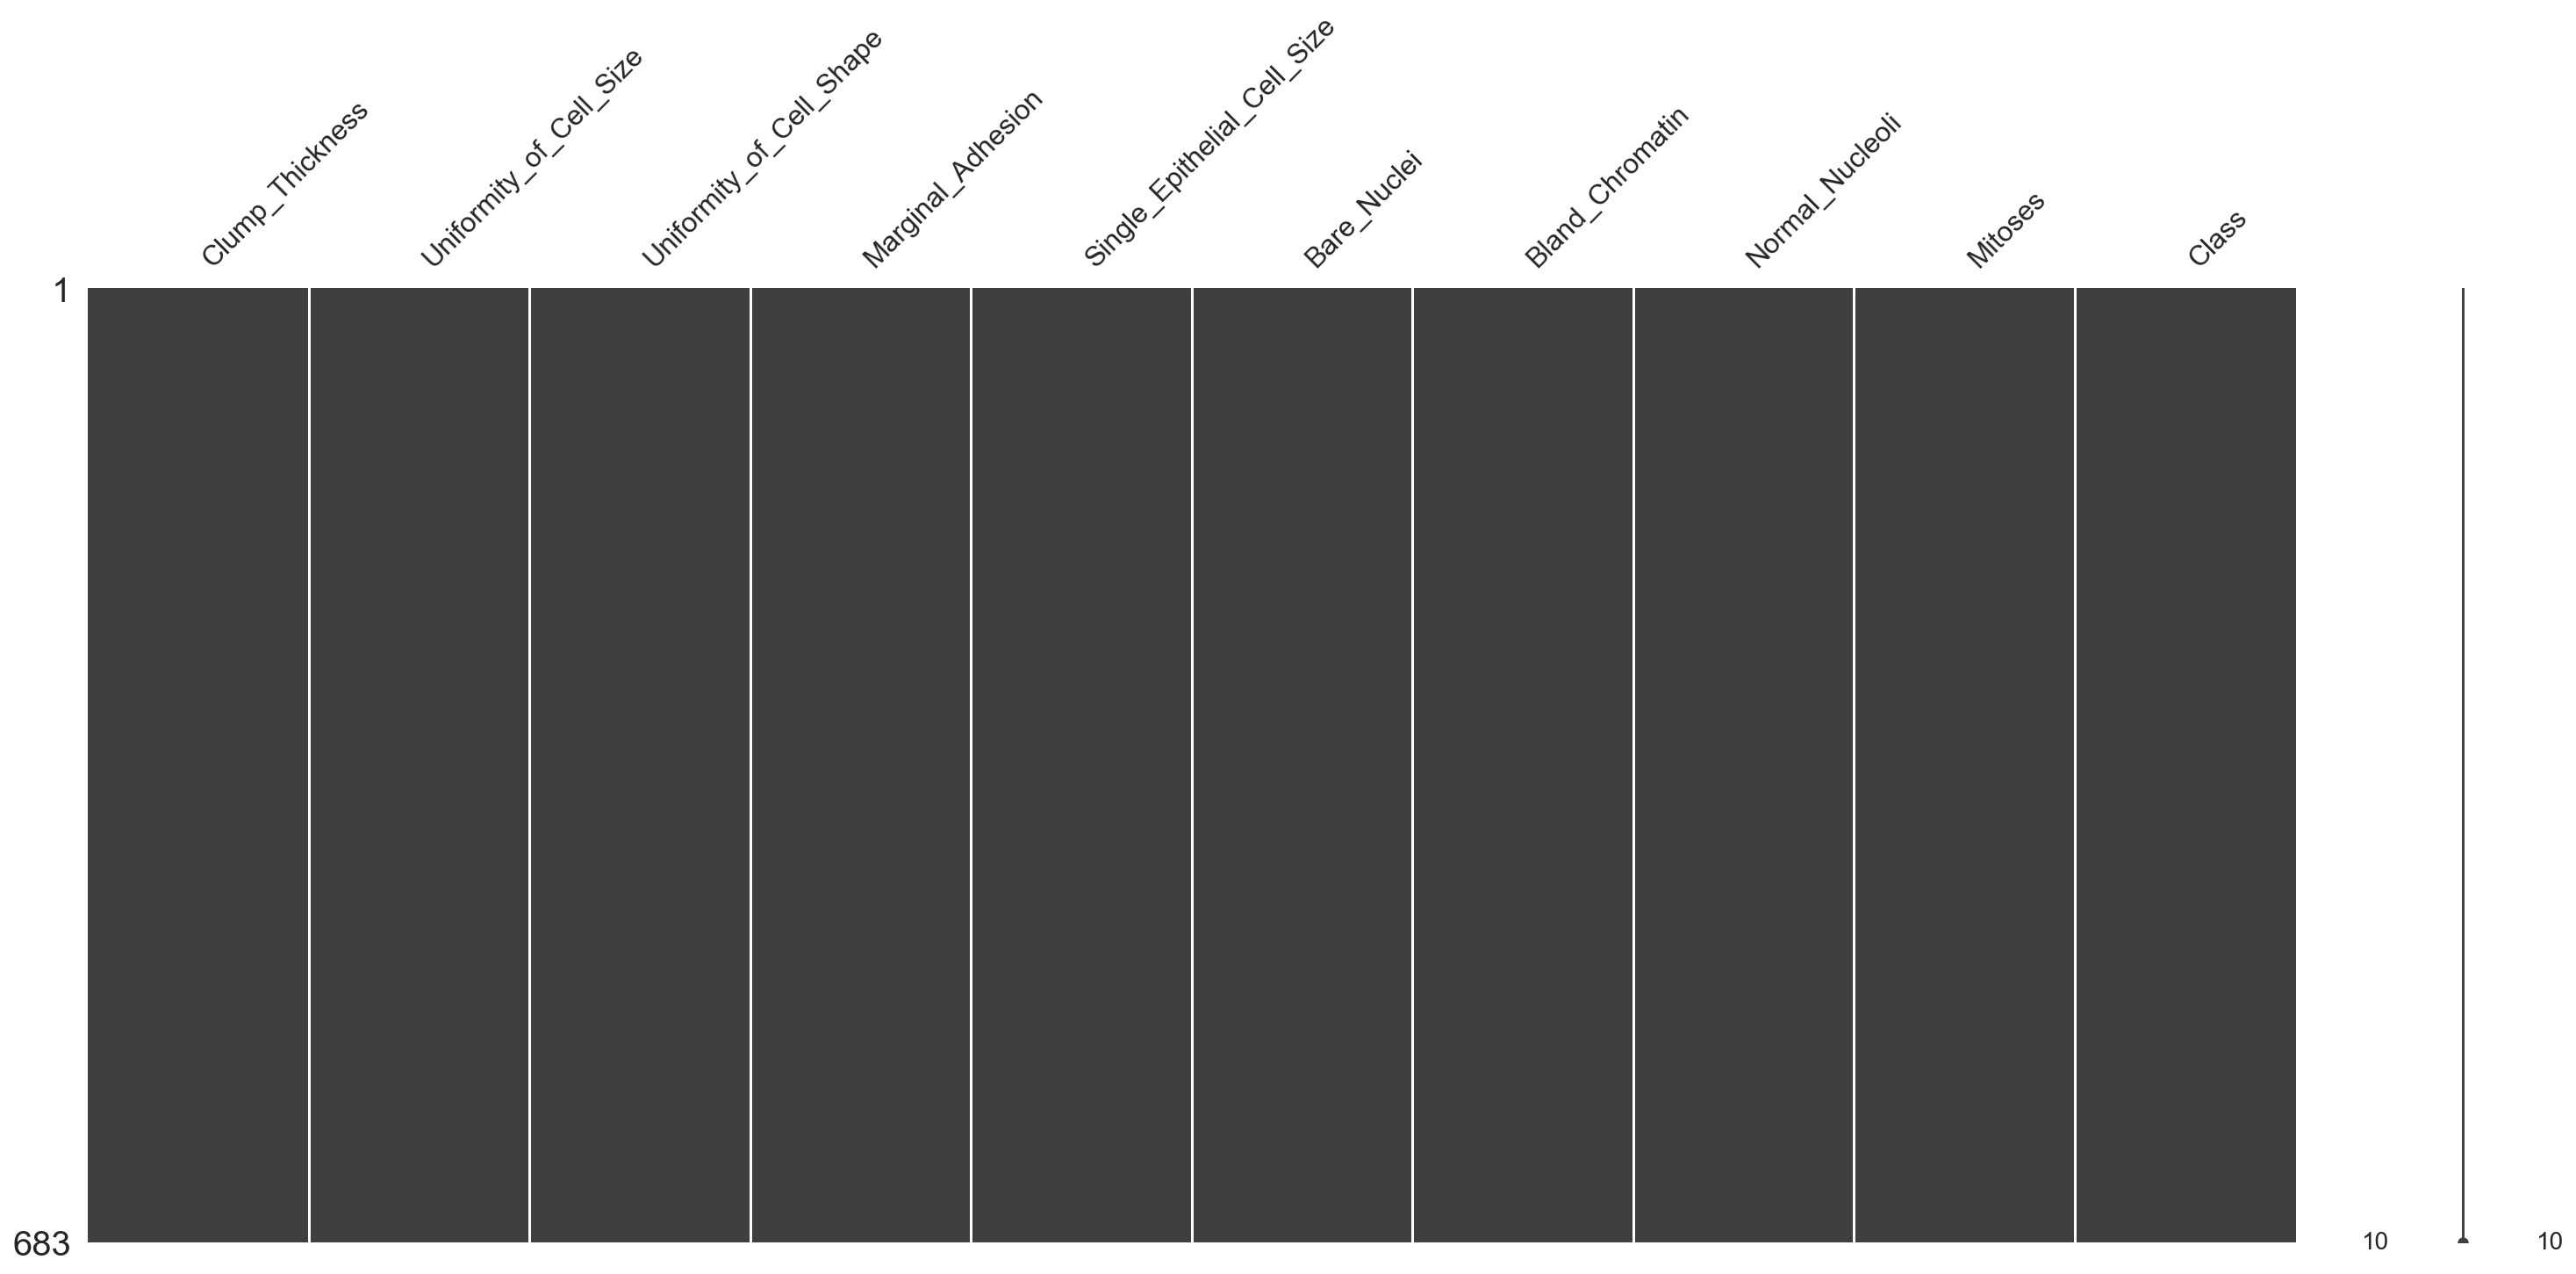

In [46]:
msgn.matrix(clean_data)

In [47]:
# Separate features from target
y = clean_data['Class']
X = clean_data.drop('Class', axis=1)

#### Finding the baseline

In [48]:
y.value_counts()

Benign       444
Malignant    239
Name: Class, dtype: int64

In [49]:
y.value_counts(normalize=True)

Benign       0.650073
Malignant    0.349927
Name: Class, dtype: float64

# Part 3: Training a Model

In [50]:
# Build a logistic regression model

lr = LogisticRegression()


In [51]:
# Build a SVM model
svc = SVC()

In [52]:
# set up an 80-20 Train-test split with random_state=1987

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1987)

In [55]:
# Fit and score the logistic regression

lr.fit(X_train,y_train)

lr.score(X_test,y_test)


0.9416058394160584

In [56]:
# Fit and score the SVM model
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.948905109489051

# Part 4: Model Evaluation

We will discuss the evaluation of classification models in detail either at the end of this class or during the next lesson. For now, our main concern is accuracy.

In [57]:
# Reminding ourselves of the baseline we are trying to beat
y_test.value_counts(normalize=True)

Benign       0.656934
Malignant    0.343066
Name: Class, dtype: float64

In [58]:
# Looking at the model accuracy
lr.score(X_test, y_test)

0.9416058394160584

Our model is very accurate, but is it confident in its predictions? Could we trust it to automate the diagnosis of some patients?

In [59]:
y_proba = lr.predict_proba(X_test)

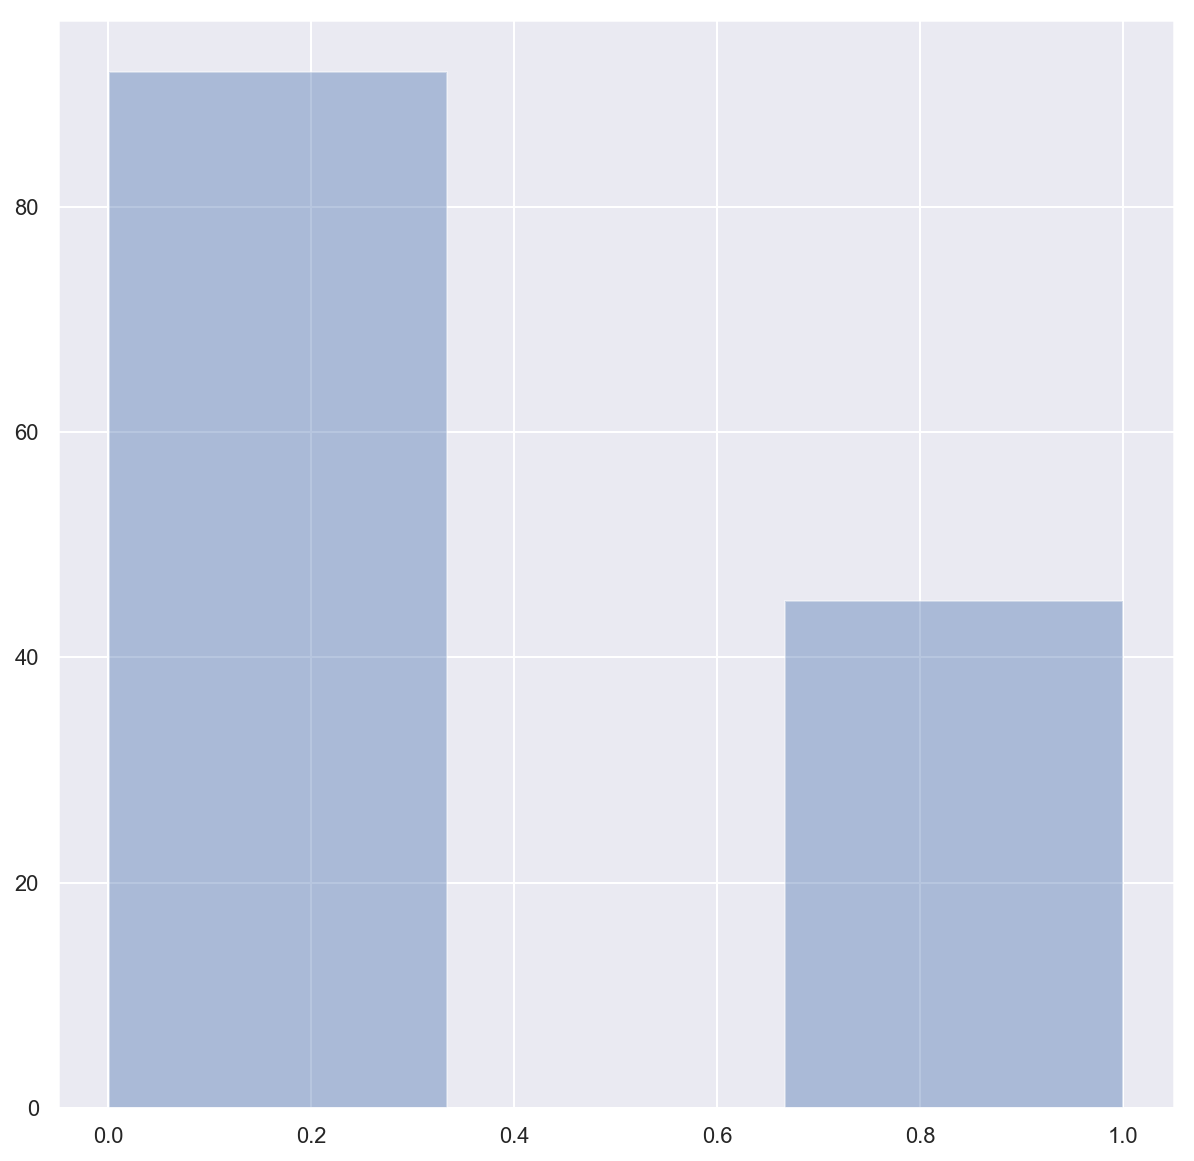

In [60]:
sns.distplot(y_proba[:,1], kde=False)

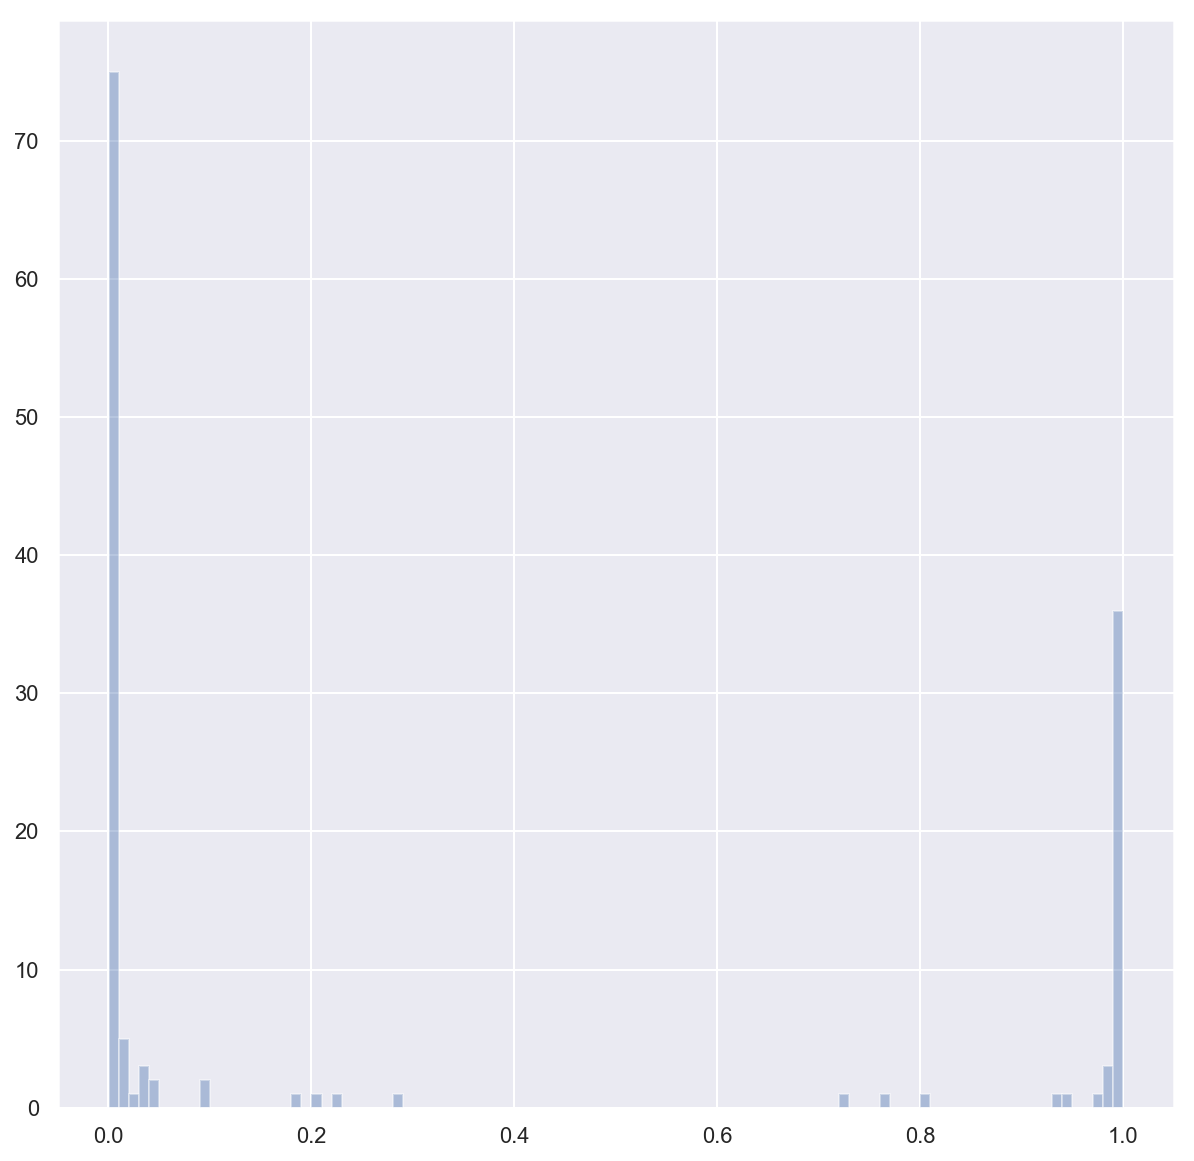

In [61]:
sns.distplot(y_proba[:,1], bins=100, kde=False)

In [62]:
# Ideally we'd also spend some time looking at the confusion matrix.

# Code Summary

In [63]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Reading the data
df = pd.read_csv('./data/cancer_uci.csv', index_col='Unnamed: 0')

# Dropping an unusable column
data = df.drop(['Sample_code_number'], axis=1)

# Identifying missing numbers
data['Bare_Nuclei'] = data['Bare_Nuclei'].apply(lambda x: np.nan if x =='?' else float(x))

# Dropping the few rows with missing numbers
clean_data = data.dropna(how='any')

# Separating the target from the features
y = clean_data['Class']
X = clean_data.drop('Class', axis=1)

# Computing the baseline
print('Baseline:', y.value_counts(normalize=True)[0].round(3))

# Instantiating a Logistic Regression Model
lr = LogisticRegression()

# Instantiating a Support Vector Machine Model
svc = SVC()

# Fitting the models
lr.fit(X_train, y_train)
svc.fit(X_train, y_train)

# Scoring the models:
print('Logistic Regression:', lr.score(X_test, y_test).round(3))
print('Support Vector Machine:', svc.score(X_test, y_test).round(3))

Baseline: 0.65
Logistic Regression: 0.942
Support Vector Machine: 0.949


# BONUS WORK 1

Try using other `kernels` and `C` values in the SVM model to obtain a higher accuracy on your test set.

# BONUS WORK 2


![](https://www.researchgate.net/profile/Juan_Banda/publication/256418526/figure/fig1/AS:297921313558528@1448041384565/Confusion-matrix-example.png)

# Confusion Matrix
This is a good (if difficult) way to look at your model and where it makes mistakes.

In [64]:
# Here I'm training a deliberately good and bad model

svc_awesome = SVC(kernel='rbf')
svc_good = SVC(kernel='rbf', C=0.01)
svc_bad = SVC(kernel='sigmoid')

svc_awesome.fit(X_train, y_train)
svc_good.fit(X_train, y_train)
svc_bad.fit(X_train, y_train)

print(svc_awesome.score(X_test, y_test))
print(svc_good.score(X_test, y_test))
print(svc_bad.score(X_test, y_test))

0.948905109489051
0.9416058394160584
0.4306569343065693


### Let's look at confusion matrices again

A confusion matrix allows you to visualize the performance of an algorithm on a test set of data vs known true values. There are a few methods 

| Metric  | Description  | Output  |
|-----|-----|-----|
|[metrics.confusion_matrix(y_true, y_pred)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)| Compute confusion matrix to evaluate the accuracy of a classification | Grid |
|[metrics.multilabel_confusion_matrix(y_true, …)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix)| Compute a confusion matrix for each class or sample | Grid |
|[metrics.plot_confusion_matrix(estimator, X, …)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix)| Plot Confusion Matrix | Plot |
|[metrics.ConfusionMatrixDisplay(...)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)| Confusion Matrix visualization| Plot |

In [65]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, svc_awesome.predict(X_test))

array([[87,  3],
       [ 4, 43]])

![](https://www.researchgate.net/profile/Juan_Banda/publication/256418526/figure/fig1/AS:297921313558528@1448041384565/Confusion-matrix-example.png)

In [66]:
def make_confusion_matrix(y_true, X, model):
    classes = model.classes_
    confusion_matrix_values = confusion_matrix(y_true, model.predict(X), labels=classes)
    data_frame = pd.DataFrame(confusion_matrix_values, columns=classes, index=classes)
    return data_frame

In [75]:
make_confusion_matrix(y_test,X_test, svc_awesome)

,Benign,Malignant
Benign,87,3
Malignant,4,43


## Or... my way

My motto is 

>**Data Scientists are curious but inherently lazy.**

If you find confusion matrices... well confusing then there's probably a better way. The number of TP/FP/TN/FN are important, but the ratios and metrics derived from them are more important. Let's resort to just using those

[Documentation in Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [68]:
# Using the classification_report package in sklearn.metrics gives the results we want.

from sklearn.metrics import classification_report
print(classification_report(y_test, svc_awesome.predict(X_test)))

              precision    recall  f1-score   support

      Benign       0.96      0.97      0.96        90
   Malignant       0.93      0.91      0.92        47

    accuracy                           0.95       137
   macro avg       0.95      0.94      0.94       137
weighted avg       0.95      0.95      0.95       137



Remember precision is penalized by false positives and recall by false negatives:

$$\text{Precision:    } \frac{TP}{TP+FP}$$

$$\text{Recall:    } \frac{TP}{TP+FN}$$

$$\text{F1:    } \frac{\text{Precision} * \text{Recall} }{\text{Precision} + \text{Recall}}$$


Support is simply the number of samples in that category.

In [76]:
# What is the confusion matrix for the good model
make_confusion_matrix(y_test,X_test, svc_good)

,Benign,Malignant
Benign,87,3
Malignant,5,42


In [77]:
# What is the confusion matrix for the bad model
make_confusion_matrix(y_test,X_test, svc_bad)

,Benign,Malignant
Benign,59,31
Malignant,47,0


# Food for thought

In the case of a model that predicts if a tumor is benign or malignant, which of the following should you pay the most attention to?

1. True Positive Rate
2. True Negative Rate
3. False Positive Rate
4. False Negative Rate